# Week 4 Toturial
This notebook serves as support material to implement several local search algorithms in **Chapter 4 - Beyond Classical Search**, i.e., `hill climbing`, `simulated annealing`, `local beam search`, and `genetic algorithm`. We continue to solve the same problem in Week 2 Toturial, i.e., four-coloring problem by these few local search algorithms.


# Problem formulation

First of all, let's review the problem formulation:

Using only four colors, you have to color a planar map in such a way that no two adjacent regions have the same color.

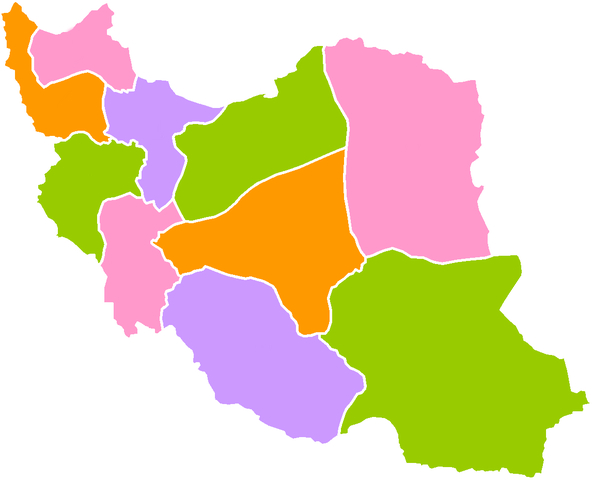

* `Initial state`: No regions colored. 
* `Actions`: Assign a color to an uncolored region. 
* `Transition model`: The previously uncolored region has the assigned color. 
* `Goal test`: All regions colored, and no two adjacent regions have the same color. 

Local search algorithms do not need to maintain a search tree, so the data structure of the current node need only record the state and the value of the objective function (a.k.a. `fitness`). Accordingly, the `cost function` can be redefined as the number of invoking `check_fitness` function. The `fitnes` value here represents how many regions are correctly colored without conflict.

Import the necessary packages and define the global variables.

In [1]:
import cv2
import numpy as np
import sys
from matplotlib import pyplot as plt
from PIL import Image
import queue
import random
import psutil
import time
import datetime
try:
    MAP_IMAGE_PATH = "iran.jpg"
except IndexError:
    print("Error: please specify an image.")
    sys.exit()

count = 0  ## record the number of invoking `check_fitness` function.
verbose_mode = False # True for dynamic visulization
ESCAPE_KEY_CHARACTER = 27
NO_COLOR = -1
NOT_MARKED = -1
BACKGROUND_MARK = -2
SLEEP_TIME_IN_MILLISECONDS = 10
MINIMUM_BORDER_WIDTH_RATIO = 0.15
IMPORTANT_COLOR_HIGH_THRESHOLD = 256 - 35
IMPORTANT_COLOR_LOW_THRESHOLD = 35
MINIMUM_REGION_AREA_RATIO = 0.0005
MAXIMUM_NEIGHBOR_PIXEL_COLOR_DIFFERENCE = 50
INF = 10 ** 30
MAXIMUM_NUMBER_OF_REGIONS = 1000
COLORING_COLORS = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (0, 255, 255)]## define four colors
DX = [-1, +1, 0, 0] ##left, right, down, up
DY = [0, 0, -1, +1] ##left, right, down, up
SHARPEN_KERNEL = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
MAXIMUM_IMAGE_WIDTH = 1000
MAXIMUM_IMAGE_HEIGHT = 1000

Perform the same preprocessing steps in Week 2 Tutorial.

In [2]:
# Initialization

image = cv2.imread(MAP_IMAGE_PATH, cv2.IMREAD_COLOR) ## input image
height = len(image)
width = len(image[0])
if width > MAXIMUM_IMAGE_WIDTH or height > MAXIMUM_IMAGE_HEIGHT:
    print("Error: please specify an image with smaller dimensions.")
    sys.exit()
total_area = width * height
mark = [[NOT_MARKED for i in range(width)] for j in range(height)] #mark matrix
nodes = [] ## node list
regions = [[] for i in range(MAXIMUM_NUMBER_OF_REGIONS)] # regions matrix
regions_border = [[] for i in range(MAXIMUM_NUMBER_OF_REGIONS)] # border matrix

# Apply thresholds to discriminate regions from background.

def apply_threshold():
    for y in range(height):
        for x in range(width):
            b, g, r = image[y][x]
            r, g, b = int(r), int(g), int(b) # red, green, blue
            if r + g + b < IMPORTANT_COLOR_LOW_THRESHOLD * 3:
                image[y][x] = (255, 255, 255)
                mark[y][x] = BACKGROUND_MARK
            if r + g + b > IMPORTANT_COLOR_HIGH_THRESHOLD * 3:
                image[y][x] = (255, 255, 255)
                mark[y][x] = BACKGROUND_MARK
                
# Remove noise from the image.
print('Please wait for preprocessing...')
apply_threshold()
image = cv2.medianBlur(image, 3) #remove noise
apply_threshold()
image = cv2.filter2D(image, -1, SHARPEN_KERNEL) #remove noise
apply_threshold()

# Define node structure.
class Node:
    def __init__(self, node_id, node_x, node_y):
        self.id = node_id
        self.x = node_x
        self.y = node_y
        self.adj = []
    def add_edge(self, node):
        self.adj.append(node.id)

# Find the node in graph.

def is_inside(x, y):  ##judge the pixel inside the image
    if x < 0 or x >= width or y < 0 or y >= height:
        return False
    return True

def same_pixel_colors(x1, y1, x2, y2): #exist minor coloring differences
    if not is_inside(x1, y1) or not is_inside(x2, y2):
        return False
    b1, g1, r1 = image[y1][x1]
    b2, g2, r2 = image[y2][x2]
    r1, g1, b1 = int(r1), int(g1), int(b1)
    r2, g2, b2 = int(r2), int(g2), int(b2)
    diff = abs(r1 - r2) + abs(g1 - g2) + abs(b1 - b2)
    return diff <= 3 * MAXIMUM_NEIGHBOR_PIXEL_COLOR_DIFFERENCE

def is_on_border(x, y):
    if mark[y][x] == BACKGROUND_MARK: #background
        return False
    for k in range(4):
        x2 = x + DX[k]
        y2 = y + DY[k]
        if is_inside(x2, y2) and mark[y2][x2] == BACKGROUND_MARK: #start point is not background while neighbor point is background
            return True
    return False

def get_region_area(start_x, start_y, src_mark, dst_mark):
    if not is_inside(start_x, start_y) or mark[start_y][start_x] != src_mark: # if marked skip
        return 0
    color_area = 0
    queue = [(start_x, start_y)] #create a queue
    mark[start_y][start_x] = dst_mark # label the pixel
    while queue:
        x, y = queue.pop(0)
        mark[y][x] = dst_mark
        color_area += 1
        for k in range(4): #left, right, up, down
            x2 = x + DX[k]
            y2 = y + DY[k]
            if is_inside(x2, y2) and mark[y2][x2] == src_mark and same_pixel_colors(x, y, x2, y2):
                mark[y2][x2] = dst_mark
                queue.append((x2, y2))
    return color_area

def get_all_regions_pixels():
    for y in range(height):
        for x in range(width):
            region_mark = mark[y][x]  #group pixels into each region
            regions[region_mark].append((x, y))
            if is_on_border(x, y): # if on border, add to the region border matrix
                regions_border[region_mark].append((x, y))

def find_graph_nodes():
    for y in range(height):
        for x in range(width):
            if mark[y][x] == NOT_MARKED:
                color_area = get_region_area(x, y, NOT_MARKED, len(nodes))
                if color_area > MINIMUM_REGION_AREA_RATIO * total_area: #region needs to be larger than the minimum area
                    nodes.append(Node(len(nodes), x, y))
                else:
                    get_region_area(x, y, len(nodes), NOT_MARKED) #otherwise mark as background
    get_all_regions_pixels()
    
find_graph_nodes()

# Next we need to append edges to the graph.

def are_adjacent(node1:Node, node2:Node):
    start_x, start_y = node1.x, node1.y #node 1 start point
    end_x, end_y = node2.x, node2.y #node 2 start point
    min_distance_sqr = INF
    for u in regions_border[mark[start_y][start_x]]: #find the nearest points between two regions
        for v in regions_border[mark[end_y][end_x]]:
            tmp_distance_sqr = (u[0] - v[0]) **2 + (u[1] - v[1]) **2
            if tmp_distance_sqr < min_distance_sqr:
                min_distance_sqr = tmp_distance_sqr
                start_x, start_y = u[0], u[1] #reset
                end_x, end_y = v[0], v[1]
    dx, dy = end_x - start_x, end_y - start_y
    if abs(dx) + abs(dy) <= 1: #adjacent
        return True
    dx, dy = float(dx), float(dy)
    border_width_threshold = MINIMUM_BORDER_WIDTH_RATIO * (width * width + height * height)
    if min_distance_sqr >= border_width_threshold: #global judge
        return False
    total_steps = int(2 * ((width **2 + height **2) ** 0.5))
    for i in range(total_steps): #local search
        x = int(start_x + i * dx / total_steps + 0.5)
        y = int(start_y + i * dy / total_steps + 0.5)
        if mark[y][x] >= 0 and (x != start_x or y != start_y) and (x != end_x or y != end_y):
            return False
    return True

def add_graph_edges():
    for i in range(len(nodes)):
        for j in range(len(nodes)):
            if j > i and are_adjacent(nodes[i], nodes[j]): #judge whether node i and node j are neighboring
                nodes[i].add_edge(nodes[j])
                nodes[j].add_edge(nodes[i])

add_graph_edges()

# Whiten the background.

def whiten_background():
    for y in range(height):
        for x in range(width):
            if mark[y][x] == NOT_MARKED or mark[y][x] == BACKGROUND_MARK:
                image[y][x] = (255, 255, 255)
whiten_background()

# Define a function to change region's color for a target region

def change_region_color(node:Node, pixel_color): # coloring all pixel in the same region
    region_idx = mark[node.y][node.x]
    for i in range(len(regions[region_idx])):
        x = regions[region_idx][i][0]
        y = regions[region_idx][i][1]
        image[y][x] = pixel_color
        
# Define a function to dynamic visulization.

def show_image(solution):
    for i in range(len(nodes)):
        change_region_color(nodes[i], COLORING_COLORS[solution[i]])
    cv2.imshow('Colorized Map', image)
    key = cv2.waitKey(SLEEP_TIME_IN_MILLISECONDS)
    if key == ESCAPE_KEY_CHARACTER:
        cv2.destroyAllWindows()         
        exit()

def show_final_image():
    img = Image.fromarray(image, 'RGB')
    img.show()
    
print('Preprocessing finished.')

Please wait for preprocessing...
Preprocessing finished.


Define the `check_fitness` function.

In [3]:
def check_fitness(solution): #solution record each region's color
    global count
    global verbose_mode
    count += 1
    valid_area = 0 # the number of valid regions
    for i in range(len(solution)):
        flag = True
        for u in nodes[i].adj:
            if solution[u] == solution[i]: # conflict
                flag = False
                break
        if flag == True:
            valid_area += 1
    if verbose_mode:
        show_image(solution) # show image after checking fitness
    return valid_area

# Hill-climbing search

Instead using the search tree (i.e., search each possible candidate solution for regions step by step), local search algorithms are useful for solving the four-cloring problem as a pure optimization problems, in which the aim is to find the best state according to an objective function. Many optimization problems do not fit the “standard” search model introduced in Chapter 3.For example, nature provides an objective function—reproductive fitness—that Darwinian evolution could be seen as attempting to optimize, but there is no “goal test” and no “path cost” for this problem.

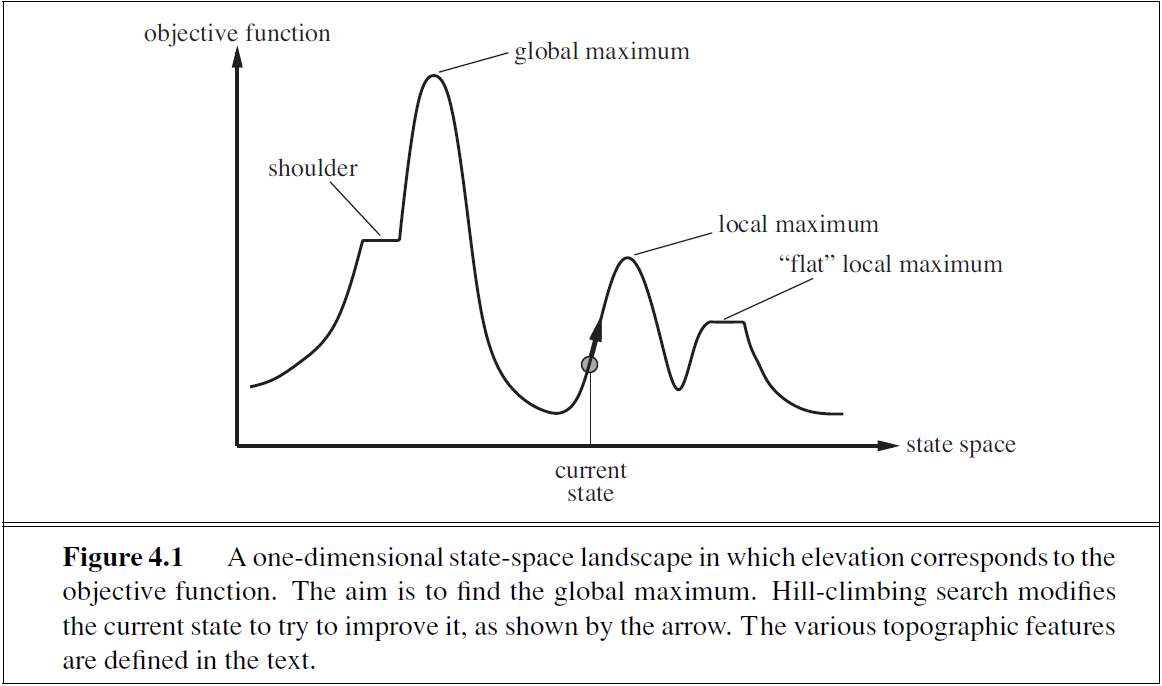

The `hill climbing` search algorithm (steepest-ascent version) is shown in Fig 4.2. It is simply a loop that continually moves in the direction of increasing value -that is, uphill. It terminates when it reaches a "peak" where no neighbor has a higher value. `Hill climbing` does not look ahead beyond the immediate neighbors of the current state. This resembles trying to find the top of Mount Everest in a thick fog while suffering from amnesia.

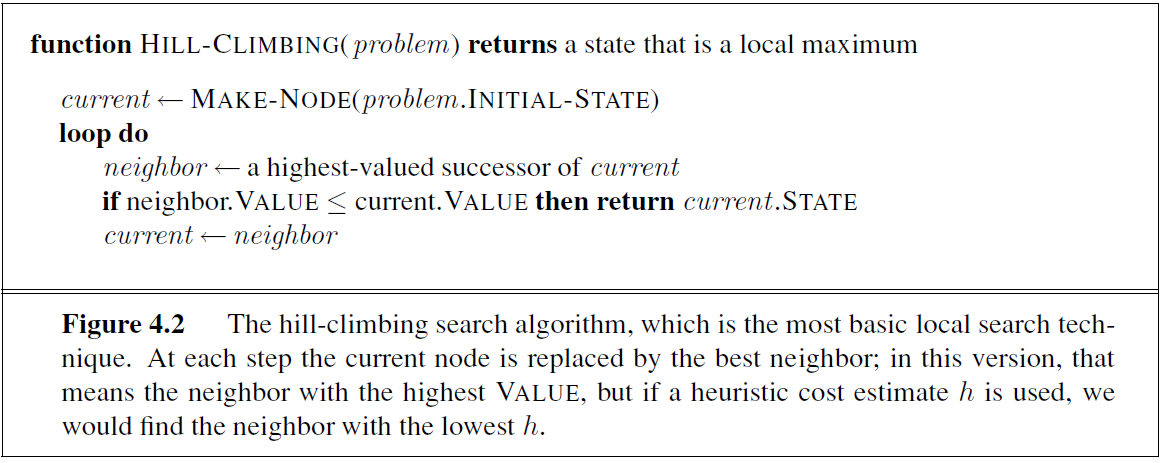




Now we can implement the `hill climbing` search algorithm according to the pseudo-code in Fig 4.2. 

In [4]:
def find_neighbor(solution):
    
    #Initialization
    current_fitness = check_fitness(solution)
    max_solution = solution
    max_value = current_fitness
    
    #find the next neighbor has a highest value
    for i in range(len(solution)):
        for j in range(1,len(COLORING_COLORS)): # try another three colors
            temp = solution
            temp[i] = (temp[i] + j) % len(COLORING_COLORS) #mod 
            if check_fitness(temp) > max_value:
                max_solution = temp
                max_value = check_fitness(temp)
    
    return max_solution
            
def hill_climbing():
    global count    
    count = 0
    
    # generate a random solution
    current = [random.randint(0, len(COLORING_COLORS)-1) for i in range(len(nodes))] 
    while True:
        neighbor = find_neighbor(current)
        if check_fitness(neighbor) > check_fitness(current):
            current = neighbor
        else: #skip the local optimum by randomization
            current[random.randint(0, len(nodes)-1)] = random.randint(0, len(COLORING_COLORS)-1)
            
        if check_fitness(current) == len(nodes): #find a valid solution
            return current

# Simulated annealing

A hill-climbing algorithm that *never* makes “downhill” moves toward states with lower value (or higher cost) is guaranteed to be incomplete, because it can get stuck on a local maximum. In contrast, a purely random walk—that is, moving to a successor chosen uniformly at random from the set of successors—is complete but extremely inefficient. Therefore, it seems reasonable to try to combine hill climbing with a random walk in some way that yields both efficiency and completeness. 

`Simulated annealing` is such an algorithm. In metallurgy, `annealing` is the process used to temper or harden metals and glass by heating them to a high temperature and then gradually cooling them, thus allowing the material to reach a lowenergycrystalline state. To explain simulated annealing, we switch our point of view from hill climbing to **gradient descent** (i.e., minimizing cost) and imagine the task of getting a ping-pong ball into the deepest crevice in a bumpy surface. If we just let the ball roll, it will come to rest at a local minimum. If we shake the surface, we can bounce the ball out of the local minimum. 

The trick is to shake just hard enough to bounce the ball out of local minima but not hard enough to dislodge it from the global minimum. The simulated-annealing
solution is to start by shaking hard (i.e., at a high temperature) and then gradually reduce the intensity of the shaking (i.e., lower the temperature).

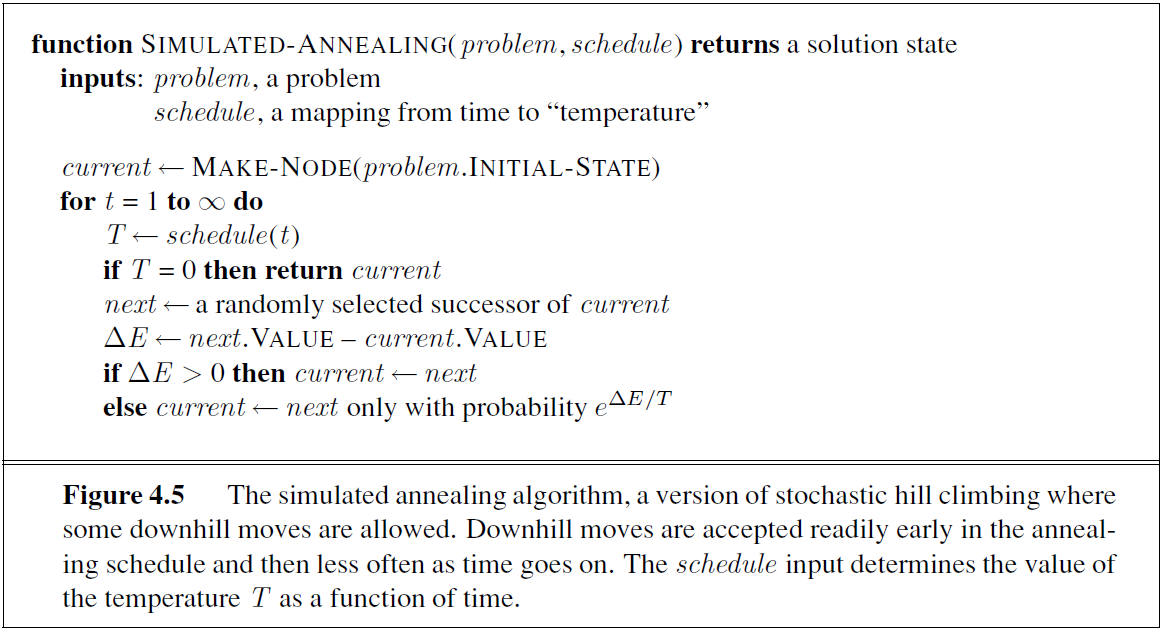

The innermost loop of the simulated-annealing algorithm (Figure 4.5) is quite similar to
hill climbing. Instead of picking the best move, however, it picks a random move. If the move improves the situation, it is always accepted. Otherwise, the algorithm accepts the move with some probability less than 1. The probability decreases exponentially with the “badness” of the move—the amount *ΔE* by which the evaluation is worsened. The probability also decreases as the “temperature” *T* goes down: “bad” moves are more likely to be allowed at the start when T is high, and they become more unlikely as T decreases. If the schedule lowers T slowly enough, the algorithm will find a global optimum with probability approaching 1.

In [5]:
def exp_schedule(k=20, lam=0.005, limit=99999):
    """One possible schedule function for simulated annealing"""
    return lambda t: (k * np.exp(-lam * t) if t < limit else 0)
        
def simulated_annealing(schedule=exp_schedule()):
    global count    
    count = 0
    # Initialization: generate a random solution
    current = [random.randint(0, len(COLORING_COLORS)-1) for i in range(len(nodes))]
    
    for t in range(sys.maxsize):
        T = schedule(t)
        #T goes to 0 or find a valid solution, then return the current solution
        if T == 0 or check_fitness(current) == len(nodes): 
            return current
        next_rand = list(current)
        next_rand[random.randint(0, len(nodes)-1)] = random.randint(0, len(COLORING_COLORS)-1)
        delta_e = check_fitness(next_rand) - check_fitness(current)
        if delta_e > 0 or np.exp(delta_e / T): # next only with probability e^(delta_e/T)
            current =  list(next_rand)

# Local beam search

Keeping just one node in memory might seem to be an extreme reaction to the problem of memory limitations.The `local beam search` algorithm keeps track of *k* states rather than just one. It begins with k randomly generated states. At each step, all the successors of all k states are generated. If any one is a goal, the algorithm halts. Otherwise, it selects the k best successors from the complete list and repeats.

At first sight, a local beam search with *k* states might seem to be nothing more than
running *k* random restarts in parallel instead of in sequence. In fact, the two algorithms are quite different. In a random-restart search, each search process runs independently of the others. In a `local beam search`, useful information is passed among the parallel search threads. In effect, the states that generate the best successors say to the others, “Come over here, the grass is greener!” The algorithm quickly abandons unfruitful searches and moves its resources to where the most progress is being made.

As there is no psuedo-code available in the book, please refer to https://www.slideshare.net/hemak15/lecture-26-local-beam-search-71648392 for more information.

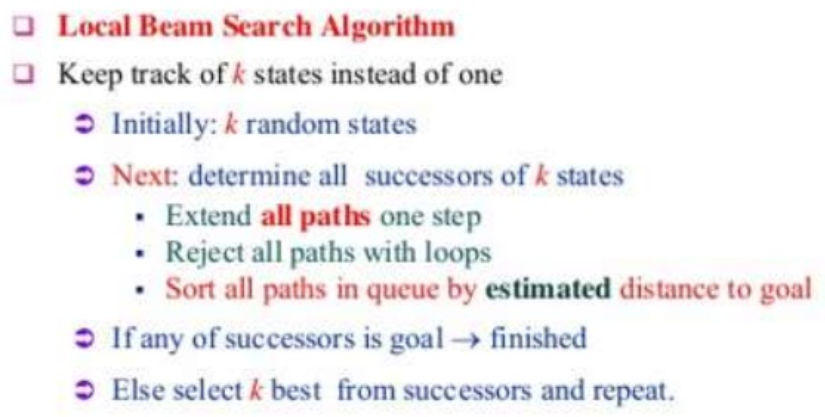


In [6]:
def local_beam(K): # K state
    global count    
    count = 0
    current = [ [random.randint(0, len(COLORING_COLORS)-1) for i in range(len(nodes))] 
               for j in range(K) ] # generate a random solution
    value_set = [ check_fitness(current[i]) for i in range(K)]
    
    #determine all successors of K states
    while True:
        candidate = [] #candidate solutions
        candidate_value = [] 
        for i in range(K): # extend all paths one step
            for j in range(len(nodes)):
                for k in range(1,len(COLORING_COLORS)): # try another three colors
                    temp = list(current[i])
                    temp[j] = (temp[j] + k) % len(COLORING_COLORS) #mod 
                    if check_fitness(temp) == len(nodes): #find a valid solution
                        return temp
                    delta = check_fitness(temp) - min(value_set)
                    if delta > 0 and (temp not in candidate):
                        candidate.append(temp)
                        candidate_value.append(check_fitness(temp))
        
        candidate_value = np.array(candidate_value)
        sort = candidate_value.argsort() #min -> max
    
        for i in range(K):# select k best from successors and repeat
            current[i] = list(candidate[sort[-(i+1)]])
        value_set = [ check_fitness(current[i]) for i in range(K)]

# Genetic algorithms

A genetic algorithm (or GA) is a variant of stochastic beam search in which successor states are generated by combining two parent states rather than by modifying a single state. The analogy to natural selection is the same as in stochastic beam search, except that now we are dealing with sexual rather than asexual reproduction.

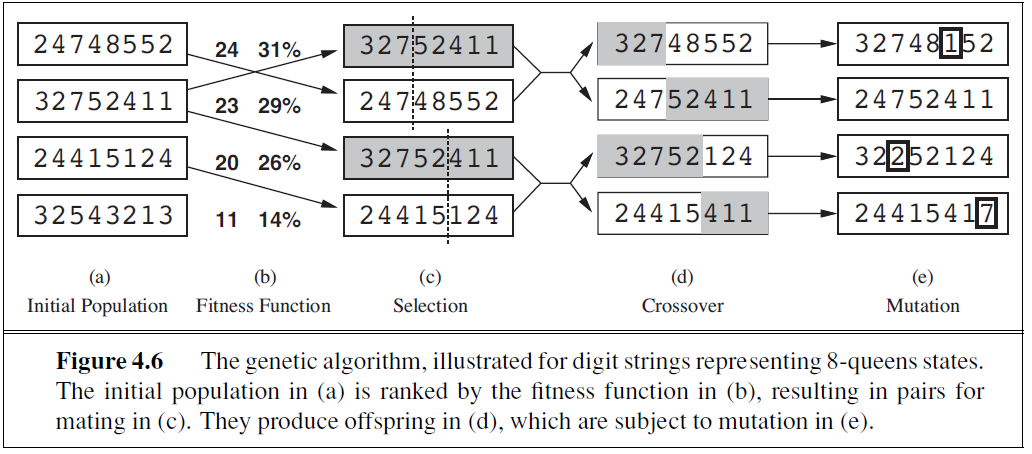

Like beam searches, GAs begin with a set of k randomly generated states, called the
population. Each state, or individual, is represented as a string over a finite alphabet—most commonly, a string of 0s and 1s. For example, an 8-queens state must specify the positions of 8 queens, each in a column of 8 squares, and so requires $$8× log_2 8=24 $$bits. Alternatively, the state could be represented as 8 digits, each in the range from 1 to 8. (We demonstrate later that the two encodings behave differently.) Figure 4.6(a) shows a population of four 8-digit strings representing 8-queens states.

The production of the next generation of states is shown in Figure 4.6(b)–(e). In (b),
each state is rated by the objective function, or (in GA terminology) the fitness function. A fitness function should return higher values for better states, so, for the 8-queens problem we use the number of nonattacking pairs of queens, which has a value of 28 for a solution. The values of the four states are 24, 23, 20, and 11. In this particular variant of the genetic algorithm, the probability of being chosen for reproducing is directly proportional to the fitness score, and the percentages are shown next to the raw scores.

In (c), two pairs are selected at random for reproduction, in accordance with the probabilities in (b). Notice that one individual is selected twice and one not at all.4 For each pair to be mated, a crossover point is chosen randomly from the positions in the string. In Figure 4.6, the crossover points are after the third digit in the first pair and after the fifth digit in the second pair.

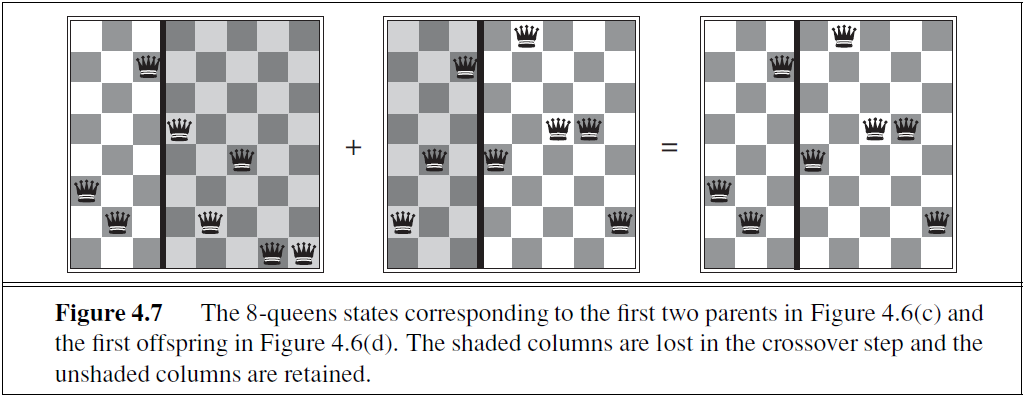
In (d), the offspring themselves are created by crossing over the parent strings at the
crossover point. For example, the first child of the first pair gets the first three digits from the first parent and the remaining digits from the second parent, whereas the second child gets the first three digits from the second parent and the rest from the first parent. The 8-queens states involved in this reproduction step are shown in Figure 4.7. The example shows that when two parent states are quite different, the crossover operation can produce a state that is a long way from either parent state. It is often the case that the population is quite diverse early on in the process, so crossover (like simulated annealing) frequently takes large steps in the state space early in the search process and smaller steps later on when most individuals are quite similar.

Finally, in (e), each location is subject to random mutation with a small independent
probability. One digit was mutated in the first, third, and fourth offspring. In the 8-queens problem, this corresponds to choosing a queen at random and moving it to a random square in its column. Figure 4.8 describes an algorithm that implements all these steps.

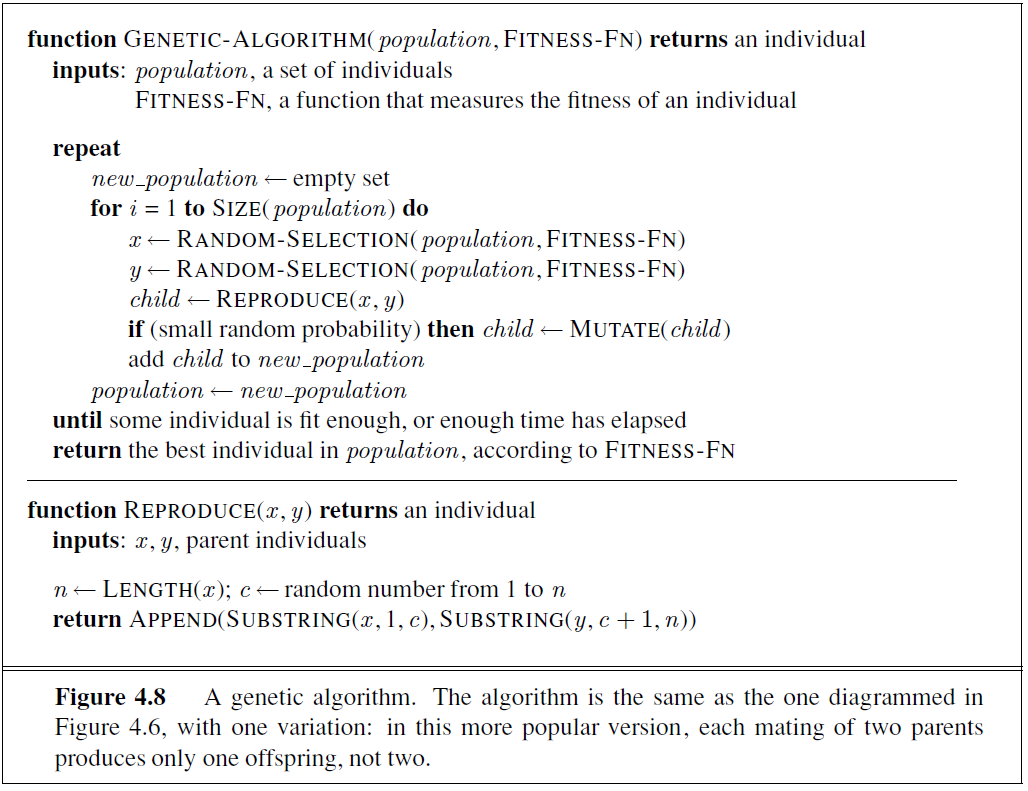

In [7]:
def init_population(pop_number, gene_pool, state_length):
    """Initializes population for genetic algorithm
    pop_number  :  Number of individuals in population
    gene_pool   :  List of possible values for individuals
    state_length:  The length of each individual"""
    g = len(gene_pool)
    population = []
    for i in range(pop_number):
        new_individual = [gene_pool[random.randrange(0, g)] for j in range(state_length)]
        population.append(new_individual)

    return population

def random_selection(population, value_set):
    #higher fitnees value, higher probability to be selected
    probability = np.array(value_set) / len(nodes)
    for i in range (len(population)):
        probability[i] = probability[i] * random.random()
    return population[probability.argmax()]

def reproduce(x, y):
    n = len(x)
    c = random.randrange(0, n)
    return x[:c] + y[c:]

def mutate(x, gene_pool, pmut):
    if random.uniform(0, 1) >= pmut:
        return x

    n = len(x)
    g = len(gene_pool)
    c = random.randrange(0, n)
    r = random.randrange(0, g)

    new_gene = gene_pool[r]
    return x[:c] + [new_gene] + x[c + 1:]
        
def genetic_algorithm(pop_number, pmut):
    
    global count    
    count = 0
    
    population = init_population(pop_number, [i for i in range(len(COLORING_COLORS))], len(nodes))
    value_set = [ check_fitness(population[i]) for i in range(pop_number)]
    
    while True:
        new_population = []
        for i in range(pop_number):
            x = random_selection(population, value_set)
            y = random_selection(population, value_set)
            child = reproduce(x, y)
            child = mutate(child, [i for i in range(len(COLORING_COLORS))], pmut)
            new_population.append(child)
        population = list(new_population)
        value_set = [ check_fitness(population[i]) for i in range(pop_number)]
        if len(nodes) in value_set: #find a valid solution
            return population[value_set.index(len(nodes))]

Now we can try different local search algorithms and observe the difference among them in terms of the efficiency. To reduce the effect of random initialization, we aim to test each algorithm 10 times to reach the average results. [If you want to display the dynamic change, please set the global variable `verbose_mode` to **True** at the beginning.]

In [8]:
#hill climbing
result = 0
for i in range(10):
    solution = list(hill_climbing())
    print('The '+str(i+1)+' test for hill climbing, the number of invoking check_fitness function: ' + str(count))
    result += count
    if verbose_mode:
        for i in range(len(solution)):
            change_region_color(nodes[i], COLORING_COLORS[solution[i]])
        show_final_image()
print ('Average number: '+str(int(result/10)))

The 1 test for hill climbing, the number of invoking check_fitness function: 49409
The 2 test for hill climbing, the number of invoking check_fitness function: 23796
The 3 test for hill climbing, the number of invoking check_fitness function: 10040
The 4 test for hill climbing, the number of invoking check_fitness function: 5622
The 5 test for hill climbing, the number of invoking check_fitness function: 11164
The 6 test for hill climbing, the number of invoking check_fitness function: 65961
The 7 test for hill climbing, the number of invoking check_fitness function: 241
The 8 test for hill climbing, the number of invoking check_fitness function: 50483
The 9 test for hill climbing, the number of invoking check_fitness function: 17166
The 10 test for hill climbing, the number of invoking check_fitness function: 25868
Average number: 25975


In [9]:
#simulated_annealing
result = 0
for i in range(10):
    solution = list(simulated_annealing())
    print('The '+str(i+1)+' test for simulated annealing, the number of invoking check_fitness function: ' + str(count))
    result += count
    if verbose_mode:
        for i in range(len(solution)):
            change_region_color(nodes[i], COLORING_COLORS[solution[i]])
        show_final_image()
print ('Average number: '+str(int(result/10)))

The 1 test for simulated annealing, the number of invoking check_fitness function: 850
The 2 test for simulated annealing, the number of invoking check_fitness function: 403
The 3 test for simulated annealing, the number of invoking check_fitness function: 4027
The 4 test for simulated annealing, the number of invoking check_fitness function: 187
The 5 test for simulated annealing, the number of invoking check_fitness function: 1165
The 6 test for simulated annealing, the number of invoking check_fitness function: 88
The 7 test for simulated annealing, the number of invoking check_fitness function: 1270
The 8 test for simulated annealing, the number of invoking check_fitness function: 955
The 9 test for simulated annealing, the number of invoking check_fitness function: 2839
The 10 test for simulated annealing, the number of invoking check_fitness function: 5893
Average number: 1767


In [10]:
#local beam search
result = 0
for i in range(10):
    solution = list(local_beam(10)) #K states
    print('The '+str(i+1)+' test for local beam search, the number of invoking check_fitness function: ' + str(count))
    result += count
    if verbose_mode:
        for i in range(len(solution)):
            change_region_color(nodes[i], COLORING_COLORS[solution[i]])
        show_final_image()
print ('Average number: '+str(int(result/10)))

The 1 test for local beam search, the number of invoking check_fitness function: 1285
The 2 test for local beam search, the number of invoking check_fitness function: 934
The 3 test for local beam search, the number of invoking check_fitness function: 812
The 4 test for local beam search, the number of invoking check_fitness function: 877
The 5 test for local beam search, the number of invoking check_fitness function: 942
The 6 test for local beam search, the number of invoking check_fitness function: 902
The 7 test for local beam search, the number of invoking check_fitness function: 934
The 8 test for local beam search, the number of invoking check_fitness function: 976
The 9 test for local beam search, the number of invoking check_fitness function: 1544
The 10 test for local beam search, the number of invoking check_fitness function: 856
Average number: 1006


In [11]:
#genetic algorithm
result = 0
for i in range(10):
    solution = list(genetic_algorithm(10, 0.1)) #pop_number, probability for mutation (pmut)
    print('The '+str(i+1)+' test for genetic algorithm, the number of invoking check_fitness function: ' + str(count))
    result += count
    if verbose_mode:
        for i in range(len(solution)):
            change_region_color(nodes[i], COLORING_COLORS[solution[i]])
        show_final_image()
print ('Average number: '+str(int(result/10)))

The 1 test for genetic algorithm, the number of invoking check_fitness function: 210
The 2 test for genetic algorithm, the number of invoking check_fitness function: 100
The 3 test for genetic algorithm, the number of invoking check_fitness function: 2090
The 4 test for genetic algorithm, the number of invoking check_fitness function: 20
The 5 test for genetic algorithm, the number of invoking check_fitness function: 30
The 6 test for genetic algorithm, the number of invoking check_fitness function: 1350
The 7 test for genetic algorithm, the number of invoking check_fitness function: 780
The 8 test for genetic algorithm, the number of invoking check_fitness function: 670
The 9 test for genetic algorithm, the number of invoking check_fitness function: 40
The 10 test for genetic algorithm, the number of invoking check_fitness function: 550
Average number: 584


## References
- https://github.com/aimacode/aima-python
- https://www.slideshare.net/hemak15/lecture-26-local-beam-search-71648392
